# Libraries

In [1]:
import pickle
import re
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from textblob import TextBlob 

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

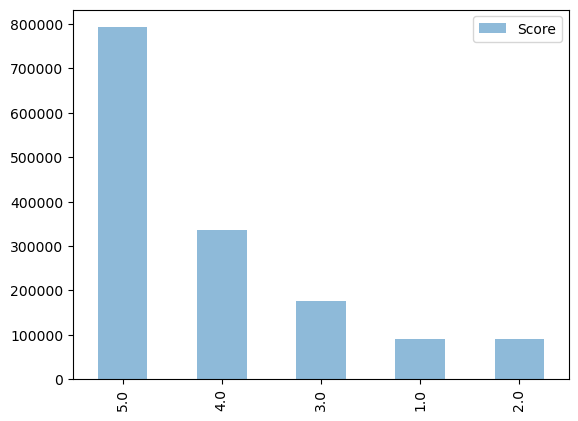


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [2]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Plotting Features

In [3]:
dfTemp = trainingSet

def count_buts(text):
    if isinstance(text, str):
        return len(re.findall(r'\bbut\b', text, re.IGNORECASE))
    return 0

# dfTemp['ButAppearance'] = dfTemp['Text'].apply(count_buts)
# dfTemp['ButAppearance'] = dfTemp['ButAppearance'].fillna(0)

# plt.scatter(dfTemp['Score'], dfTemp['ButAppearance'])
# plt.xlabel("score")
# plt.ylabel("but appearances")
# plt.show()

def percent_caps(text):
    if not isinstance(text, str) or len(text) == 0:
        return 0  # Avoid division by zero if the string is empty
    uppercase_count = sum(1 for char in text if char.isupper())
    return (uppercase_count / len(text)) * 100

# dfTemp['PercentCaps'] = dfTemp['Summary'].apply(percent_caps)
# dfTemp['PercentCaps'] = dfTemp['PercentCaps'].fillna(0)
# plt.scatter(dfTemp['Score'], dfTemp['PercentCaps'])
# plt.xlabel("Score")
# plt.ylabel("Percent Caps")
# plt.show()

def is_empty(text):
    if not isinstance(text, str) or len(text) == 0:
        return 1
    return 0

# dfTemp['isEmpty'] = dfTemp['Text'].apply(is_empty)
# dfTemp['isEmpty'] = dfTemp['isEmpty'].fillna(0)

# score_empty_counts = dfTemp.groupby('Score')['isEmpty'].sum()

# # Plotting the results
# plt.bar(score_empty_counts.index, score_empty_counts.values)
# plt.xlabel("Score")
# plt.ylabel("Sum of Empty Occurrences")
# plt.show()

def exclamation_points(text):
    if isinstance(text, str):
        return len(re.findall(r'\b!\b', text))
    return 0

# dfTemp['ExclamationPoint'] = dfTemp['Text'].apply(exclamation_points)

# plt.scatter(dfTemp['Score'], dfTemp['ExclamationPoint'])
# plt.xlabel("Score")
# plt.ylabel("Number of Exclamation Points")
# plt.show()

# TF-IDF

In [11]:
from sklearn.model_selection import train_test_split
import re
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np
from scipy.stats import mode

data = trainingSet
trainingSet.drop(columns=['HelpfulnessNumerator', 'Time', 'Summary'])
# Split a subset of data (e.g., 20%) for analysis
_, data_subset = train_test_split(data, test_size=0.2, random_state=42)
# _, data_subset = train_test_split(data, test_size=0.2, stratify=data['Score'], random_state=42)


# Download NLTK data if you haven't already
nltk.download('stopwords')
stop_words = stopwords.words('english')

def preprocess_text(text):
    return ' '.join([word.lower() for word in text.split() if word.lower() not in stop_words])

# TODO: Apply the preprocessing function to the 'content' column
# data['processed_content'] = data['Text'].apply(preprocess_text)
data_subset['processed_content'] = data_subset['Text'].fillna('').astype(str).apply(preprocess_text)
# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_df=0.05, max_features=1000, ngram_range=(1, 2))

# Create the term-document matrix
term_doc_matrix = vectorizer.fit_transform(data_subset['processed_content'])


# Apply dimensionality reduction with TruncatedSVD to the term-document matrix
svd = TruncatedSVD(n_components=300, random_state=42)
reduced_matrix = svd.fit_transform(term_doc_matrix)

# Split into features (X) and target (y)
X = reduced_matrix
y = data_subset['Score']

# Train-test split for model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = np.nan_to_num(X_train, nan=0.0, posinf=np.finfo(np.float64).max, neginf=np.finfo(np.float64).min)
y_train = np.nan_to_num(y_train, nan=0.0)

# Learn the model
model = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)

# Predict the score using the model
Y_test_predictions = model.predict(X_test)

# Calculate the mode of y_test to use for NaN replacement
y_mode = mode(y_test).mode[0]

# Replace NaNs in y_test and Y_test_predictions
y_test = np.nan_to_num(y_test, nan=y_mode)
Y_test_predictions = np.nan_to_num(Y_test_predictions, nan=y_mode)

print("Accuracy on testing set = ", accuracy_score(y_test, Y_test_predictions))


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alicehan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/alicehan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Accuracy on testing set =  0.3831551353421107


/var/folders/h7/41mkjgjj3dg0f9bbx9dcs4yc0000gn/T/ipykernel_75837/2466490057.py:55: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  y_mode = mode(y_test).mode[0]


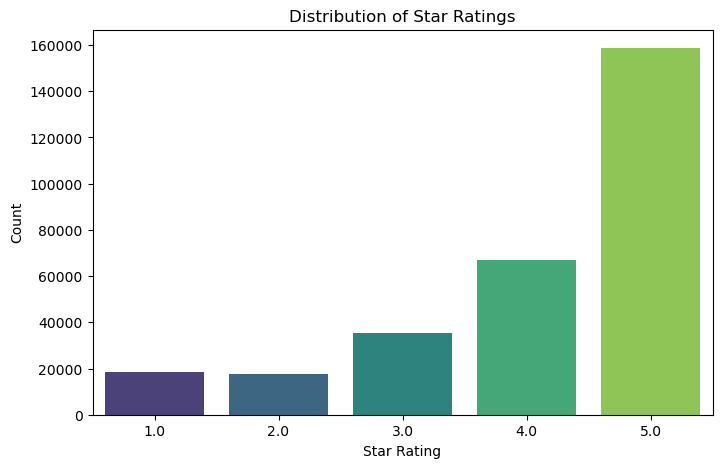

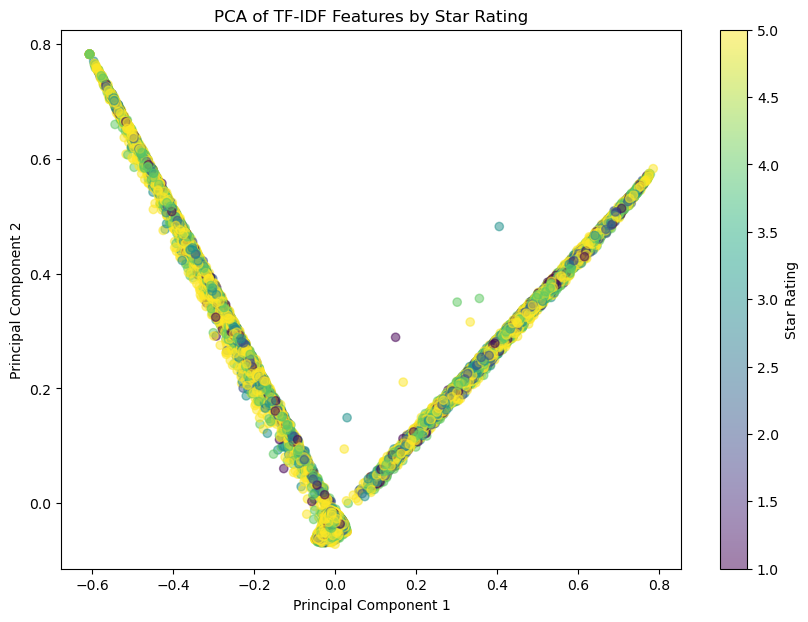

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# 1. Distribution of Star Ratings
plt.figure(figsize=(8, 5))
sns.countplot(data=data_subset, x='Score', palette="viridis")
plt.title("Distribution of Star Ratings")
plt.xlabel("Star Rating")
plt.ylabel("Count")
plt.show()

# 2. TF-IDF Feature Analysis with PCA
# Apply PCA to reduce to 2 components for plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(reduced_matrix)

# Scatter plot with colors based on 'Score'
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data_subset['Score'], cmap="viridis", alpha=0.5)
plt.colorbar(scatter, label="Star Rating")
plt.title("PCA of TF-IDF Features by Star Rating")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


In [4]:
#Pickle Functions

# Function to save objects using pickle
def save_object(obj, filename):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f)

# Function to load objects using pickle
def load_object(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

# Helper Functions

In [5]:

def stars_in_text(text):
    if isinstance(text, str):
        if "1 star" in text:
            return 1
        elif "2 star" in text:
            return 2
        elif "3 star" in text:
            return 3
        elif "4 star" in text:
            return 4
        elif "5 star" in text:
            return 5
    return 3

def count_buts(text):
    if isinstance(text, str):
        return len(re.findall(r'\bbut\b', text, re.IGNORECASE))
    return 0

def is_empty(text):
    if not isinstance(text, str) or len(text) == 0:
        return 1
    return 0

def calculate_sentiment(text):
    if isinstance(text, str):
        return TextBlob(text).sentiment.polarity  # Returns a value between -1 and 1
    return 0

# Adding Features

In [6]:
def add_features_to(df):
    # This is where you can do all your feature extraction

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    #feature that sees if number are mentioned in the review and then use that number as rating
    df['AppearsIn'] = df['Text'].apply(stars_in_text)
    df['AppearsIn'] = df['AppearsIn'].fillna(3)

    df['ButAppearance'] = df['Text'].apply(count_buts)
    df['ButAppearance'] = df['ButAppearance'].fillna(0)

    df['isEmpty'] = df['Text'].apply(is_empty)
    df['isEmpty'] = df['isEmpty'].fillna(0)

    df['SummarySentiment'] = df['Summary'].apply(calculate_sentiment)
    df['SummarySentiment'] = df['SummarySentiment'].fillna(0)

    df['TextSentiment'] = df['Text'].apply(calculate_sentiment)
    df['TextSentiment'] = df['TextSentiment'].fillna(0)

    # # Extract TF-IDF features
    # vectorizer = TfidfVectorizer(max_df=0.05, max_features=1000, ngram_range=(1, 2))
    # tfidf_matrix = vectorizer.fit_transform(df['Text'].fillna(''))  # Fill NaN values with an empty string
    # # Create a DataFrame from the TF-IDF matrix
    # tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    # # Concatenate the TF-IDF features to the original DataFrame
    # df = pd.concat([df.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

    return df


# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    # Process the DataFrame
    train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)


# # UNDER HERE SHOULD TYPICIALLY BE IN DIFFERENT CELL BUT I JUST WANT IT ALL TO RUN
# # Split training set into training and testing set
# X_train, X_test, Y_train, Y_test = train_test_split(
#     X_train.drop(columns=['Score']),
#     X_train['Score'],
#     test_size=1/4.0,
#     random_state=0
# )

# features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness', 'AppearsIn', 'ButAppearance', 'isEmpty']

# X_train_select = X_train[features]
# X_test_select = X_test[features]
# X_submission_select = X_submission[features]

# # Learn the model
# model = KNeighborsClassifier(n_neighbors=3).fit(X_train_select, Y_train)

# # Predict the score using the model
# Y_test_predictions = model.predict(X_test_select)


# # Save the model and the vectorizer
# save_object(model, './data/model.pkl')
# save_object(vectorizer, './data/tfidf_vectorizer.pkl')

# Sample + Split into training and testing set

In [7]:
sample_size = 20000

# Sample 20,000 random data points from the DataFrame
sampled_X_train = X_train.sample(n=20000, random_state=0)

# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    sampled_X_train.drop(columns=['Score']),
    sampled_X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Feature Selection

In [8]:
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness', 'AppearsIn', 'ButAppearance', 'isEmpty', 'SummarySentiment', 'TextSentiment']

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Model Creation

In [ ]:
# Set a random seed for reproducibility
random_seed = 42

# Sample a smaller portion of the training data (e.g., 10%)
sample_size = int(len(X_train_select) * 0.001)  # 10% of the training data
X_train_sample = X_train_select.sample(n=sample_size, random_state=random_seed)
Y_train_sample = Y_train[X_train_sample.index]  # Select the corresponding Y values

# Sample the same number of instances from the test set
X_test_sample = X_test_select.sample(n=sample_size, random_state=random_seed)
Y_test_sample = Y_test[X_test_sample.index]  # Select the corresponding Y values

# Learn the model using SVM with default parameters
model = SVC(kernel='linear').fit(X_train_sample, Y_train_sample)

# Predict the score using the model on the sample test data
Y_test_predictions = model.predict(X_test_sample)

# Calculate and print the accuracy for the sampled data
accuracy = accuracy_score(Y_test_sample, Y_test_predictions)
print(f"Accuracy on sampled test set: {accuracy:.2f}")

# Save the model
save_object(model, './data/model_sample.pkl')


In [ ]:
# # Learn the model
# model = KNeighborsClassifier(n_neighbors=3).fit(X_train_select, Y_train)

# # Predict the score using the model
# Y_test_predictions = model.predict(X_test_select)

# Learn the model using SVM with default parameters
model = SVC().fit(X_train_select, Y_train)
model = SVC(kernel='linear').fit(X_train_select, Y_train)

# Predict the score using the model
Y_test_predictions = model.predict(X_test_select)
 
save_object(model, './data/model.pkl')

# Model Evaluation

Accuracy on testing set =  0.43157140702759766


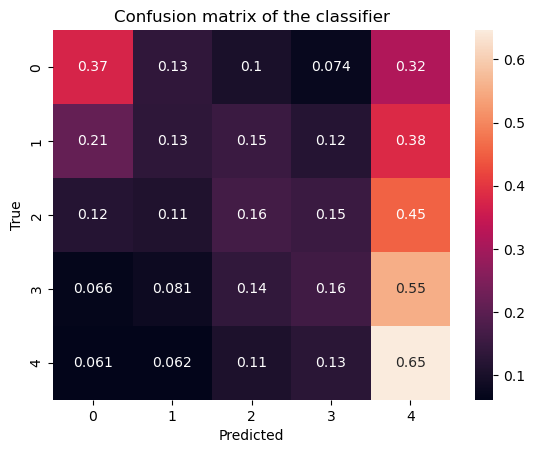

In [17]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [23]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)